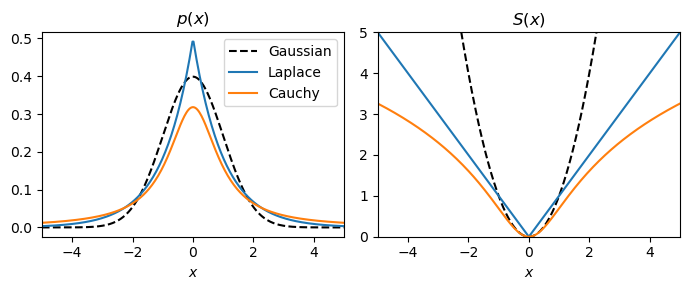

In [1]:
using PyPlot

x = range(-5, 5, length=300)
figure(figsize=(7,3))
subplot(1,2,1)
title(L"$p(x)$")
plot(x, 1/sqrt(2pi)*exp.(-(x.^2)/2), color="black", linestyle="--",label="Gaussian")
plot(x, 1/2*exp.(-abs.(x)), label="Laplace")
plot(x, 1 ./ (pi*(1 .+ x.^2)), label="Cauchy")
xlim(-5, 5); 
xlabel(L"$x$")
legend()

subplot(1,2,2)
title(L"S(x)")
plot(x, x.^2, color="black", linestyle="--",label="Gaussian")
plot(x, abs.(x), label="Laplace")
plot(x, log.(1 .+ x.^2), label="Cauchy")
xlim(-5, 5); ylim(0, 5)
xlabel(L"$x$")

tight_layout()

In [2]:
# thresholding function of S(x)=|x|
function soft_thresholding_func(x, lmda)
    max(x - lmda, 0) - max(-x - lmda, 0)
end

soft_thresholding_func (generic function with 1 method)

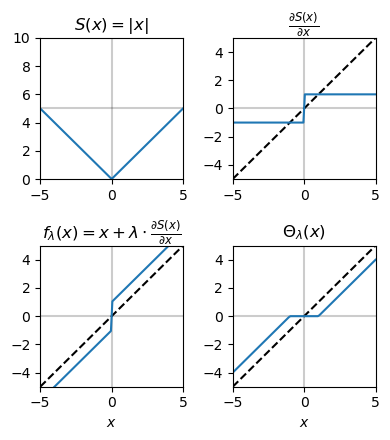

In [3]:
xmin, xmax = -5, 5
x = range(xmin, xmax, length=100)
y = soft_thresholding_func.(x, 1)

figure(figsize=(4,4.5))
subplot(2,2,1)
title(L"$S(x)=|x|$")
plot(x, abs.(x))
xlim(xmin, xmax); ylim(0, 10)
hlines(y=xmax, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=0, ymax=xmax*2, color="k", alpha=0.2)

subplot(2,2,2)
title(L"$\frac{\partial S(x)}{\partial x}$")
plot(x, x, "k--")
plot(x, sign.(x))
xlim(xmin, xmax); ylim(xmin, xmax)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

subplot(2,2,3)
title(L"$f_\lambda(x)=x+\lambda\cdot\frac{\partial S(x)}{\partial x}$")
plot(x, x, "k--")
plot(x, x + 1*sign.(x))
xlabel(L"$x$")
xlim(-5, 5); ylim(-5, 5)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

subplot(2,2,4)
title(L"$\Theta_\lambda(x)$")
plot(x, x, "k--")
plot(x, y)
xlabel(L"$x$")
xlim(-5, 5); ylim(-5, 5)
hlines(y=0, xmin=xmin, xmax=xmax, color="k", alpha=0.2)
vlines(x=0, ymin=xmin, ymax=xmax, color="k", alpha=0.2)

tight_layout()

In [4]:
using MAT
#using PyPlot

In [5]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images_raw = matopen("../_static/datasets/IMAGES_RAW.mat")
imgs_raw = read(mat_images_raw, "IMAGESr")

mat_images = matopen("../_static/datasets/IMAGES.mat")
imgs = read(mat_images, "IMAGES")

close(mat_images_raw)
close(mat_images)

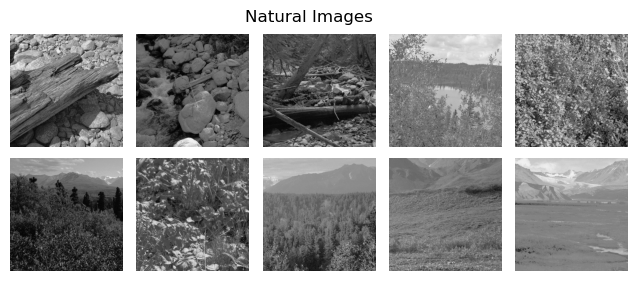

In [6]:
figure(figsize=(8, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i=1:10
    subplot(2, 5, i)
    imshow(imgs_raw[:,:,i], cmap="gray")
    axis("off")
end
suptitle("Natural Images", fontsize=12)
subplots_adjust(top=0.9)  

In [7]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra
using Random
using Statistics
using ProgressMeter

In [8]:
@kwdef struct OFParameter{FT}
    lr_r::FT = 1e-2 # learning rate of r
    lr_Phi::FT = 1e-2 # learning rate of Phi
    lmda::FT = 5e-3 # regularization parameter
end

@kwdef mutable struct OlshausenField1996Model{FT}
    param::OFParameter = OFParameter{FT}()
    num_inputs::Int32
    num_units::Int32
    batch_size::Int32
    r::Array{FT} = zeros(batch_size, num_units) # activity of neurons
    Phi::Array{FT} = randn(num_inputs, num_units) .* sqrt(1/num_units)
end

In [9]:
function updateOF!(variable::OlshausenField1996Model, param::OFParameter, inputs::Array, training::Bool)
    @unpack num_inputs, num_units, batch_size, r, Phi = variable
    @unpack lr_r, lr_Phi, lmda = param

    # Updates                
    error = inputs .- r * Phi'
    r_ = r +lr_r .* error * Phi

    r[:, :] = soft_thresholding_func.(r_, lmda)

    if training 
        error = inputs - r * Phi'
        dPhi = error' * r
        Phi[:, :] += lr_Phi * dPhi
    end
    
    return error
end

updateOF! (generic function with 1 method)

In [10]:
function normalize_rows(A::Array)
    return A ./ sqrt.(sum(A.^2, dims=1) .+ 1e-8)
end

normalize_rows (generic function with 1 method)

In [11]:
function calculate_total_error(error, r, lmda)
    recon_error = mean(error.^2)
    sparsity_r = lmda*mean(abs.(r)) 
    return recon_error + sparsity_r
end

calculate_total_error (generic function with 1 method)

In [12]:
function run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)
    H, W, num_images = size(imgs)
    num_inputs = sz^2

    model = OlshausenField1996Model{Float32}(num_inputs=num_inputs, num_units=num_units, batch_size=batch_size)
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-sz, batch_size)
        beginy = rand(1:H-sz, batch_size)

        inputs = zeros(batch_size, num_inputs)  # Input image patches

        # Get images randomly
        for i in 1:batch_size        
            idx = rand(1:num_images)
            img = imgs[:, :, idx]
            clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
            inputs[i, :] = clop .- mean(clop)
        end

        model.r = zeros(batch_size, num_units) # Reset r states
        model.Phi = normalize_rows(model.Phi) # Normalize weights
        # Input image patches until latent variables are converged 
        r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

        for t in 1:nt_max
            # Update r without update weights 
            error = updateOF!(model, model.param, inputs, false)

            dr = model.r - r_tm1 

            # Compute norm of r
            dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
            r_tm1 .= model.r # update r_tm1

            # Check convergence of r, then update weights
            if dr_norm < eps
                error = updateOF!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if t >= nt_max-1
                print("Error at patch:", iter_, dr_norm)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end
        end
        # Print moving average error
        if iter % 100 == 0
            moving_average_error = mean(errorarr[iter-99:iter])
            println("iter: ", iter, "/", num_iter, ", Moving average error:", moving_average_error)
        end
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

In [13]:
# Simulation constants
num_iter = 500 # number of iterations
nt_max = 1000 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 16 # image patch size
num_units = 100 # number of neurons (units)
eps = 1e-2 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)

Computing...  0%|█                                      |  ETA: 0:23:27

Computing...  1%|█                                      |  ETA: 0:10:52

Computing...  1%|█                                      |  ETA: 0:08:50

Computing...  1%|█                                      |  ETA: 0:07:38

Computing...  1%|█                                      |  ETA: 0:06:48

Computing...  1%|█                                      |  ETA: 0:06:13

Computing...  2%|█                                      |  ETA: 0:05:46

Computing...  2%|█                                      |  ETA: 0:05:26

Computing...  2%|█                                      |  ETA: 0:05:09

Computing...  2%|█                                      |  ETA: 0:04:55

Computing...  2%|█                                      |  ETA: 0:04:44

Computing...  3%|██                                     |  ETA: 0:04:33

Computing...  3%|██                                     |  ETA: 0:04:25

Computing...  3%|██                                     |  ETA: 0:04:18

Computing...  3%|██                                     |  ETA: 0:04:11

Computing...  3%|██                                     |  ETA: 0:04:05

Computing...  4%|██                                     |  ETA: 0:04:00

Computing...  4%|██                                     |  ETA: 0:03:55

Computing...  4%|██                                     |  ETA: 0:03:51

Computing...  4%|██                                     |  ETA: 0:03:47

Computing...  4%|██                                     |  ETA: 0:03:43

Computing...  5%|██                                     |  ETA: 0:03:40

Computing...  5%|██                                     |  ETA: 0:03:36

Computing...  5%|██                                     |  ETA: 0:03:33

Computing...  5%|███                                    |  ETA: 0:03:31

Computing...  5%|███                                    |  ETA: 0:03:28

Computing...  6%|███                                    |  ETA: 0:03:27

Computing...  6%|███                                    |  ETA: 0:03:25

Computing...  6%|███                                    |  ETA: 0:03:24

Computing...  6%|███                                    |  ETA: 0:03:22

Computing...  6%|███                                    |  ETA: 0:03:20

Computing...  7%|███                                    |  ETA: 0:03:18

Computing...  7%|███                                    |  ETA: 0:03:16

Computing...  7%|███                                    |  ETA: 0:03:14

Computing...  7%|███                                    |  ETA: 0:03:12

Computing...  7%|███                                    |  ETA: 0:03:10

Computing...  8%|███                                    |  ETA: 0:03:09

Computing...  8%|████                                   |  ETA: 0:03:08

Computing...  8%|████                                   |  ETA: 0:03:07

Computing...  8%|████                                   |  ETA: 0:03:05

Computing...  8%|████                                   |  ETA: 0:03:04

Computing...  9%|████                                   |  ETA: 0:03:03

Computing...  9%|████                                   |  ETA: 0:03:01

Computing...  9%|████                                   |  ETA: 0:03:00

Computing...  9%|████                                   |  ETA: 0:02:59

Computing...  9%|████                                   |  ETA: 0:02:58

Computing... 10%|████                                   |  ETA: 0:02:57

Computing... 10%|████                                   |  ETA: 0:02:56

Computing... 10%|████                                   |  ETA: 0:02:55

Computing... 10%|████                                   |  ETA: 0:02:54

Computing... 10%|█████                                  |  ETA: 0:02:52

Computing... 11%|█████                                  |  ETA: 0:02:52

Computing... 11%|█████                                  |  ETA: 0:02:51

Computing... 11%|█████                                  |  ETA: 0:02:50

Computing... 11%|█████                                  |  ETA: 0:02:49

Computing... 11%|█████                                  |  ETA: 0:02:48

Computing... 12%|█████                                  |  ETA: 0:02:47

Computing... 12%|█████                                  |  ETA: 0:02:46

Computing... 12%|█████                                  |  ETA: 0:02:46

Computing... 12%|█████                                  |  ETA: 0:02:45

Computing... 12%|█████                                  |  ETA: 0:02:44

Computing... 13%|█████                                  |  ETA: 0:02:43

Computing... 13%|█████                                  |  ETA: 0:02:42

Computing... 13%|██████                                 |  ETA: 0:02:41

Computing... 13%|██████                                 |  ETA: 0:02:40

Computing... 13%|██████                                 |  ETA: 0:02:39

Computing... 14%|██████                                 |  ETA: 0:02:39

Computing... 14%|██████                                 |  ETA: 0:02:38

Computing... 14%|██████                                 |  ETA: 0:02:37

Computing... 14%|██████                                 |  ETA: 0:02:36

Computing... 14%|██████                                 |  ETA: 0:02:35

Computing... 15%|██████                                 |  ETA: 0:02:35

Computing... 15%|██████                                 |  ETA: 0:02:34

Computing... 15%|██████                                 |  ETA: 0:02:33

Computing... 15%|██████                                 |  ETA: 0:02:32

Computing... 15%|███████                                |  ETA: 0:02:32

Computing... 16%|███████                                |  ETA: 0:02:31

Computing... 16%|███████                                |  ETA: 0:02:30

Computing... 16%|███████                                |  ETA: 0:02:30

Computing... 16%|███████                                |  ETA: 0:02:29

Computing... 16%|███████                                |  ETA: 0:02:28

Computing... 17%|███████                                |  ETA: 0:02:28

Computing... 17%|███████                                |  ETA: 0:02:27

Computing... 17%|███████                                |  ETA: 0:02:26

Computing... 17%|███████                                |  ETA: 0:02:25

Computing... 18%|███████                                |  ETA: 0:02:24

Computing... 18%|███████                                |  ETA: 0:02:24

Computing... 18%|████████                               |  ETA: 0:02:23

Computing... 18%|████████                               |  ETA: 0:02:23

Computing... 18%|████████                               |  ETA: 0:02:22

Computing... 19%|████████                               |  ETA: 0:02:21

Computing... 19%|████████                               |  ETA: 0:02:21

Computing... 19%|████████                               |  ETA: 0:02:20

Computing... 19%|████████                               |  ETA: 0:02:20

Computing... 19%|████████                               |  ETA: 0:02:19

Computing... 20%|████████                               |  ETA: 0:02:19

Computing... 20%|████████                               |  ETA: 0:02:18

Computing... 20%|████████                               |  ETA: 0:02:18

iter: 100/500, Moving average error:0.05286214882468668


Computing... 20%|████████                               |  ETA: 0:02:17

Computing... 20%|████████                               |  ETA: 0:02:17

Computing... 21%|█████████                              |  ETA: 0:02:16

Computing... 21%|█████████                              |  ETA: 0:02:16

Computing... 21%|█████████                              |  ETA: 0:02:14

Computing... 21%|█████████                              |  ETA: 0:02:14

Computing... 22%|█████████                              |  ETA: 0:02:14

Computing... 22%|█████████                              |  ETA: 0:02:13

Computing... 22%|█████████                              |  ETA: 0:02:12

Computing... 22%|█████████                              |  ETA: 0:02:12

Computing... 22%|█████████                              |  ETA: 0:02:11

Computing... 23%|█████████                              |  ETA: 0:02:11

Computing... 23%|█████████                              |  ETA: 0:02:11

Computing... 23%|█████████                              |  ETA: 0:02:10

Computing... 23%|██████████                             |  ETA: 0:02:10

Computing... 23%|██████████                             |  ETA: 0:02:09

Computing... 24%|██████████                             |  ETA: 0:02:09

Computing... 24%|██████████                             |  ETA: 0:02:08

Computing... 24%|██████████                             |  ETA: 0:02:08

Computing... 24%|██████████                             |  ETA: 0:02:07

Computing... 24%|██████████                             |  ETA: 0:02:07

Computing... 25%|██████████                             |  ETA: 0:02:06

Computing... 25%|██████████                             |  ETA: 0:02:06

Computing... 25%|██████████                             |  ETA: 0:02:05

Computing... 25%|██████████                             |  ETA: 0:02:05

Computing... 25%|██████████                             |  ETA: 0:02:04

Computing... 26%|██████████                             |  ETA: 0:02:04

Computing... 26%|███████████                            |  ETA: 0:02:04

Computing... 26%|███████████                            |  ETA: 0:02:03

Computing... 26%|███████████                            |  ETA: 0:02:03

Computing... 26%|███████████                            |  ETA: 0:02:02

Computing... 27%|███████████                            |  ETA: 0:02:02

Computing... 27%|███████████                            |  ETA: 0:02:02

Computing... 27%|███████████                            |  ETA: 0:02:01

Computing... 27%|███████████                            |  ETA: 0:02:01

Computing... 27%|███████████                            |  ETA: 0:02:00

Computing... 28%|███████████                            |  ETA: 0:02:00

Computing... 28%|███████████                            |  ETA: 0:01:59

Computing... 28%|███████████                            |  ETA: 0:01:59

Computing... 28%|███████████                            |  ETA: 0:01:58

Computing... 28%|████████████                           |  ETA: 0:01:58

Computing... 29%|████████████                           |  ETA: 0:01:58

Computing... 29%|████████████                           |  ETA: 0:01:57

Computing... 29%|████████████                           |  ETA: 0:01:57

Computing... 29%|████████████                           |  ETA: 0:01:56

Computing... 29%|████████████                           |  ETA: 0:01:56

Computing... 30%|████████████                           |  ETA: 0:01:55

Computing... 30%|████████████                           |  ETA: 0:01:55

Computing... 30%|████████████                           |  ETA: 0:01:55

Computing... 30%|████████████                           |  ETA: 0:01:54

Computing... 30%|████████████                           |  ETA: 0:01:54

Computing... 31%|████████████                           |  ETA: 0:01:53

Computing... 31%|█████████████                          |  ETA: 0:01:53

Computing... 31%|█████████████                          |  ETA: 0:01:53

Computing... 31%|█████████████                          |  ETA: 0:01:52

Computing... 31%|█████████████                          |  ETA: 0:01:52

Computing... 32%|█████████████                          |  ETA: 0:01:51

Computing... 32%|█████████████                          |  ETA: 0:01:51

Computing... 32%|█████████████                          |  ETA: 0:01:51

Computing... 32%|█████████████                          |  ETA: 0:01:50

Computing... 32%|█████████████                          |  ETA: 0:01:50

Computing... 33%|█████████████                          |  ETA: 0:01:49

Computing... 33%|█████████████                          |  ETA: 0:01:49

Computing... 33%|█████████████                          |  ETA: 0:01:49

Computing... 33%|█████████████                          |  ETA: 0:01:48

Computing... 33%|██████████████                         |  ETA: 0:01:48

Computing... 34%|██████████████                         |  ETA: 0:01:48

Computing... 34%|██████████████                         |  ETA: 0:01:47

Computing... 34%|██████████████                         |  ETA: 0:01:47

Computing... 34%|██████████████                         |  ETA: 0:01:46

Computing... 34%|██████████████                         |  ETA: 0:01:46

Computing... 35%|██████████████                         |  ETA: 0:01:46

Computing... 35%|██████████████                         |  ETA: 0:01:45

Computing... 35%|██████████████                         |  ETA: 0:01:45

Computing... 35%|██████████████                         |  ETA: 0:01:44

Computing... 35%|██████████████                         |  ETA: 0:01:44

Computing... 36%|██████████████                         |  ETA: 0:01:44

Computing... 36%|██████████████                         |  ETA: 0:01:43

Computing... 36%|███████████████                        |  ETA: 0:01:43

Computing... 36%|███████████████                        |  ETA: 0:01:43

Computing... 36%|███████████████                        |  ETA: 0:01:42

Computing... 37%|███████████████                        |  ETA: 0:01:42

Computing... 37%|███████████████                        |  ETA: 0:01:41

Computing... 37%|███████████████                        |  ETA: 0:01:41

Computing... 37%|███████████████                        |  ETA: 0:01:41

Computing... 37%|███████████████                        |  ETA: 0:01:40

Computing... 38%|███████████████                        |  ETA: 0:01:40

Computing... 38%|███████████████                        |  ETA: 0:01:40

Computing... 38%|███████████████                        |  ETA: 0:01:39

Computing... 38%|███████████████                        |  ETA: 0:01:39

Computing... 38%|███████████████                        |  ETA: 0:01:38

Computing... 39%|████████████████                       |  ETA: 0:01:38

Computing... 39%|████████████████                       |  ETA: 0:01:38

Computing... 39%|████████████████                       |  ETA: 0:01:37

Computing... 39%|████████████████                       |  ETA: 0:01:37

Computing... 39%|████████████████                       |  ETA: 0:01:37

Computing... 40%|████████████████                       |  ETA: 0:01:36

Computing... 40%|████████████████                       |  ETA: 0:01:36

Computing... 40%|████████████████                       |  ETA: 0:01:36

iter: 200/500, Moving average error:0.04836060645437683


Computing... 40%|████████████████                       |  ETA: 0:01:35

Computing... 40%|████████████████                       |  ETA: 0:01:35

Computing... 41%|████████████████                       |  ETA: 0:01:34

Computing... 41%|████████████████                       |  ETA: 0:01:34

Computing... 41%|████████████████                       |  ETA: 0:01:34

Computing... 41%|█████████████████                      |  ETA: 0:01:33

Computing... 41%|█████████████████                      |  ETA: 0:01:33

Computing... 42%|█████████████████                      |  ETA: 0:01:33

Computing... 42%|█████████████████                      |  ETA: 0:01:32

Computing... 42%|█████████████████                      |  ETA: 0:01:32

Computing... 42%|█████████████████                      |  ETA: 0:01:32

Computing... 42%|█████████████████                      |  ETA: 0:01:31

Computing... 43%|█████████████████                      |  ETA: 0:01:31

Computing... 43%|█████████████████                      |  ETA: 0:01:31

Computing... 43%|█████████████████                      |  ETA: 0:01:30

Computing... 43%|█████████████████                      |  ETA: 0:01:30

Computing... 44%|██████████████████                     |  ETA: 0:01:29

Computing... 44%|██████████████████                     |  ETA: 0:01:29

Computing... 44%|██████████████████                     |  ETA: 0:01:28

Computing... 44%|██████████████████                     |  ETA: 0:01:28

Computing... 44%|██████████████████                     |  ETA: 0:01:28

Computing... 45%|██████████████████                     |  ETA: 0:01:27

Computing... 45%|██████████████████                     |  ETA: 0:01:27

Computing... 45%|██████████████████                     |  ETA: 0:01:27

Computing... 45%|██████████████████                     |  ETA: 0:01:26

Computing... 45%|██████████████████                     |  ETA: 0:01:26

Computing... 46%|██████████████████                     |  ETA: 0:01:26

Computing... 46%|██████████████████                     |  ETA: 0:01:25

Computing... 46%|██████████████████                     |  ETA: 0:01:25

Computing... 46%|███████████████████                    |  ETA: 0:01:25

Computing... 46%|███████████████████                    |  ETA: 0:01:24

Computing... 47%|███████████████████                    |  ETA: 0:01:24

Computing... 47%|███████████████████                    |  ETA: 0:01:24

Computing... 47%|███████████████████                    |  ETA: 0:01:23

Computing... 47%|███████████████████                    |  ETA: 0:01:23

Computing... 47%|███████████████████                    |  ETA: 0:01:23

Computing... 48%|███████████████████                    |  ETA: 0:01:22

Computing... 48%|███████████████████                    |  ETA: 0:01:22

Computing... 48%|███████████████████                    |  ETA: 0:01:22

Computing... 48%|███████████████████                    |  ETA: 0:01:21

Computing... 48%|███████████████████                    |  ETA: 0:01:21

Computing... 49%|███████████████████                    |  ETA: 0:01:21

Computing... 49%|████████████████████                   |  ETA: 0:01:20

Computing... 49%|████████████████████                   |  ETA: 0:01:20

Computing... 49%|████████████████████                   |  ETA: 0:01:20

Computing... 49%|████████████████████                   |  ETA: 0:01:19

Computing... 50%|████████████████████                   |  ETA: 0:01:19

Computing... 50%|████████████████████                   |  ETA: 0:01:19

Computing... 50%|████████████████████                   |  ETA: 0:01:18

Computing... 50%|████████████████████                   |  ETA: 0:01:18

Computing... 50%|████████████████████                   |  ETA: 0:01:18

Computing... 51%|████████████████████                   |  ETA: 0:01:17

Computing... 51%|████████████████████                   |  ETA: 0:01:17

Computing... 51%|████████████████████                   |  ETA: 0:01:17

Computing... 51%|████████████████████                   |  ETA: 0:01:16

Computing... 51%|█████████████████████                  |  ETA: 0:01:16

Computing... 52%|█████████████████████                  |  ETA: 0:01:16

Computing... 52%|█████████████████████                  |  ETA: 0:01:15

Computing... 52%|█████████████████████                  |  ETA: 0:01:15

Computing... 52%|█████████████████████                  |  ETA: 0:01:15

Computing... 52%|█████████████████████                  |  ETA: 0:01:14

Computing... 53%|█████████████████████                  |  ETA: 0:01:14

Computing... 53%|█████████████████████                  |  ETA: 0:01:14

Computing... 53%|█████████████████████                  |  ETA: 0:01:13

Computing... 53%|█████████████████████                  |  ETA: 0:01:13

Computing... 53%|█████████████████████                  |  ETA: 0:01:13

Computing... 54%|█████████████████████                  |  ETA: 0:01:12

Computing... 54%|█████████████████████                  |  ETA: 0:01:12

Computing... 54%|██████████████████████                 |  ETA: 0:01:12

Computing... 54%|██████████████████████                 |  ETA: 0:01:11

Computing... 54%|██████████████████████                 |  ETA: 0:01:11

Computing... 55%|██████████████████████                 |  ETA: 0:01:11

Computing... 55%|██████████████████████                 |  ETA: 0:01:10

Computing... 55%|██████████████████████                 |  ETA: 0:01:10

Computing... 55%|██████████████████████                 |  ETA: 0:01:10

Computing... 55%|██████████████████████                 |  ETA: 0:01:09

Computing... 56%|██████████████████████                 |  ETA: 0:01:09

Computing... 56%|██████████████████████                 |  ETA: 0:01:09

Computing... 56%|██████████████████████                 |  ETA: 0:01:08

Computing... 56%|██████████████████████                 |  ETA: 0:01:08

Computing... 56%|██████████████████████                 |  ETA: 0:01:08

Computing... 57%|███████████████████████                |  ETA: 0:01:07

Computing... 57%|███████████████████████                |  ETA: 0:01:07

Computing... 57%|███████████████████████                |  ETA: 0:01:07

Computing... 57%|███████████████████████                |  ETA: 0:01:06

Computing... 57%|███████████████████████                |  ETA: 0:01:06

Computing... 58%|███████████████████████                |  ETA: 0:01:06

Computing... 58%|███████████████████████                |  ETA: 0:01:05

Computing... 58%|███████████████████████                |  ETA: 0:01:05

Computing... 58%|███████████████████████                |  ETA: 0:01:05

Computing... 58%|███████████████████████                |  ETA: 0:01:05

Computing... 59%|███████████████████████                |  ETA: 0:01:04

Computing... 59%|███████████████████████                |  ETA: 0:01:04

Computing... 59%|████████████████████████               |  ETA: 0:01:04

Computing... 59%|████████████████████████               |  ETA: 0:01:03

Computing... 59%|████████████████████████               |  ETA: 0:01:03

Computing... 60%|████████████████████████               |  ETA: 0:01:03

Computing... 60%|████████████████████████               |  ETA: 0:01:02

Computing... 60%|████████████████████████               |  ETA: 0:01:02

iter: 300/500, Moving average error:0.047980813296986564


Computing... 60%|████████████████████████               |  ETA: 0:01:02

Computing... 60%|████████████████████████               |  ETA: 0:01:01

Computing... 61%|████████████████████████               |  ETA: 0:01:01

Computing... 61%|████████████████████████               |  ETA: 0:01:01

Computing... 61%|████████████████████████               |  ETA: 0:01:00

Computing... 61%|████████████████████████               |  ETA: 0:01:00

Computing... 61%|████████████████████████               |  ETA: 0:01:00

Computing... 62%|█████████████████████████              |  ETA: 0:00:59

Computing... 62%|█████████████████████████              |  ETA: 0:00:59

Computing... 62%|█████████████████████████              |  ETA: 0:00:59

Computing... 62%|█████████████████████████              |  ETA: 0:00:58

Computing... 62%|█████████████████████████              |  ETA: 0:00:58

Computing... 63%|█████████████████████████              |  ETA: 0:00:58

Computing... 63%|█████████████████████████              |  ETA: 0:00:57

Computing... 63%|█████████████████████████              |  ETA: 0:00:57

Computing... 63%|█████████████████████████              |  ETA: 0:00:57

Computing... 63%|█████████████████████████              |  ETA: 0:00:56

Computing... 64%|█████████████████████████              |  ETA: 0:00:56

Computing... 64%|█████████████████████████              |  ETA: 0:00:56

Computing... 64%|█████████████████████████              |  ETA: 0:00:56

Computing... 64%|██████████████████████████             |  ETA: 0:00:55

Computing... 64%|██████████████████████████             |  ETA: 0:00:55

Computing... 65%|██████████████████████████             |  ETA: 0:00:55

Computing... 65%|██████████████████████████             |  ETA: 0:00:54

Computing... 65%|██████████████████████████             |  ETA: 0:00:54

Computing... 65%|██████████████████████████             |  ETA: 0:00:53

Computing... 66%|██████████████████████████             |  ETA: 0:00:53

Computing... 66%|██████████████████████████             |  ETA: 0:00:53

Computing... 66%|██████████████████████████             |  ETA: 0:00:52

Computing... 66%|██████████████████████████             |  ETA: 0:00:52

Computing... 66%|██████████████████████████             |  ETA: 0:00:52

Computing... 67%|██████████████████████████             |  ETA: 0:00:51

Computing... 67%|███████████████████████████            |  ETA: 0:00:51

Computing... 67%|███████████████████████████            |  ETA: 0:00:51

Computing... 67%|███████████████████████████            |  ETA: 0:00:50

Computing... 67%|███████████████████████████            |  ETA: 0:00:50

Computing... 68%|███████████████████████████            |  ETA: 0:00:50

Computing... 68%|███████████████████████████            |  ETA: 0:00:49

Computing... 68%|███████████████████████████            |  ETA: 0:00:49

Computing... 68%|███████████████████████████            |  ETA: 0:00:49

Computing... 68%|███████████████████████████            |  ETA: 0:00:49

Computing... 69%|███████████████████████████            |  ETA: 0:00:48

Computing... 69%|███████████████████████████            |  ETA: 0:00:48

Computing... 69%|███████████████████████████            |  ETA: 0:00:48

Computing... 69%|███████████████████████████            |  ETA: 0:00:47

Computing... 69%|████████████████████████████           |  ETA: 0:00:47

Computing... 70%|████████████████████████████           |  ETA: 0:00:47

Computing... 70%|████████████████████████████           |  ETA: 0:00:46

Computing... 70%|████████████████████████████           |  ETA: 0:00:46

Computing... 70%|████████████████████████████           |  ETA: 0:00:46

Computing... 70%|████████████████████████████           |  ETA: 0:00:45

Computing... 71%|████████████████████████████           |  ETA: 0:00:45

Computing... 71%|████████████████████████████           |  ETA: 0:00:45

Computing... 71%|████████████████████████████           |  ETA: 0:00:44

Computing... 71%|████████████████████████████           |  ETA: 0:00:44

Computing... 71%|████████████████████████████           |  ETA: 0:00:44

Computing... 72%|████████████████████████████           |  ETA: 0:00:43

Computing... 72%|█████████████████████████████          |  ETA: 0:00:43

Computing... 72%|█████████████████████████████          |  ETA: 0:00:43

Computing... 72%|█████████████████████████████          |  ETA: 0:00:43

Computing... 72%|█████████████████████████████          |  ETA: 0:00:42

Computing... 73%|█████████████████████████████          |  ETA: 0:00:42

Computing... 73%|█████████████████████████████          |  ETA: 0:00:42

Computing... 73%|█████████████████████████████          |  ETA: 0:00:41

Computing... 73%|█████████████████████████████          |  ETA: 0:00:41

Computing... 73%|█████████████████████████████          |  ETA: 0:00:41

Computing... 74%|█████████████████████████████          |  ETA: 0:00:40

Computing... 74%|█████████████████████████████          |  ETA: 0:00:40

Computing... 74%|█████████████████████████████          |  ETA: 0:00:40

Computing... 74%|█████████████████████████████          |  ETA: 0:00:39

Computing... 74%|██████████████████████████████         |  ETA: 0:00:39

Computing... 75%|██████████████████████████████         |  ETA: 0:00:39

Computing... 75%|██████████████████████████████         |  ETA: 0:00:38

Computing... 75%|██████████████████████████████         |  ETA: 0:00:38

Computing... 75%|██████████████████████████████         |  ETA: 0:00:38

Computing... 75%|██████████████████████████████         |  ETA: 0:00:38

Computing... 76%|██████████████████████████████         |  ETA: 0:00:37

Computing... 76%|██████████████████████████████         |  ETA: 0:00:37

Computing... 76%|██████████████████████████████         |  ETA: 0:00:37

Computing... 76%|██████████████████████████████         |  ETA: 0:00:36

Computing... 76%|██████████████████████████████         |  ETA: 0:00:36

Computing... 77%|██████████████████████████████         |  ETA: 0:00:36

Computing... 77%|██████████████████████████████         |  ETA: 0:00:35

Computing... 77%|███████████████████████████████        |  ETA: 0:00:35

Computing... 77%|███████████████████████████████        |  ETA: 0:00:35

Computing... 77%|███████████████████████████████        |  ETA: 0:00:34

Computing... 78%|███████████████████████████████        |  ETA: 0:00:34

Computing... 78%|███████████████████████████████        |  ETA: 0:00:34

Computing... 78%|███████████████████████████████        |  ETA: 0:00:34

Computing... 78%|███████████████████████████████        |  ETA: 0:00:33

Computing... 78%|███████████████████████████████        |  ETA: 0:00:33

Computing... 79%|███████████████████████████████        |  ETA: 0:00:33

Computing... 79%|███████████████████████████████        |  ETA: 0:00:32

Computing... 79%|███████████████████████████████        |  ETA: 0:00:32

Computing... 79%|███████████████████████████████        |  ETA: 0:00:32

Computing... 79%|███████████████████████████████        |  ETA: 0:00:31

Computing... 80%|████████████████████████████████       |  ETA: 0:00:31

Computing... 80%|████████████████████████████████       |  ETA: 0:00:31

Computing... 80%|████████████████████████████████       |  ETA: 0:00:30

iter: 400/500, Moving average error:0.04793236914423183


Computing... 80%|████████████████████████████████       |  ETA: 0:00:30

Computing... 80%|████████████████████████████████       |  ETA: 0:00:30

Computing... 81%|████████████████████████████████       |  ETA: 0:00:30

Computing... 81%|████████████████████████████████       |  ETA: 0:00:29

Computing... 81%|████████████████████████████████       |  ETA: 0:00:29

Computing... 81%|████████████████████████████████       |  ETA: 0:00:29

Computing... 81%|████████████████████████████████       |  ETA: 0:00:28

Computing... 82%|████████████████████████████████       |  ETA: 0:00:28

Computing... 82%|████████████████████████████████       |  ETA: 0:00:28

Computing... 82%|████████████████████████████████       |  ETA: 0:00:27

Computing... 82%|█████████████████████████████████      |  ETA: 0:00:27

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:26

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:26

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:26

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:26

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:25

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:25

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:25

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 85%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:23

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:22

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:22

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:22

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:22

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:21

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:19

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:19

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:18

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 90%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:15

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:15

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:15

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:15

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 92%|█████████████████████████████████████  |  ETA: 0:00:11

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:11

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:11

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:11

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:08

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:04

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing...100%|███████████████████████████████████████|  ETA: 0:00:01

Computing...100%|███████████████████████████████████████|  ETA: 0:00:00

Computing...100%|███████████████████████████████████████| Time: 0:02:30


iter: 500/500, Moving average error:0.04769756553822845


(OlshausenField1996Model{Float32}(OFParameter{Float32}(0.01f0, 0.01f0, 0.005f0), 256, 100, 250, Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.18681301 0.2481708 … 0.056822766 0.0106076505; 0.0 0.0 … 0.0 0.0], Float32[0.023467677 -0.019379795 … -0.018685674 0.00852896; 0.035926357 -0.025200497 … -0.0026787173 0.011524568; … ; 0.0034877467 0.042624768 … 0.014210868 -0.29532745; 0.017397966 0.03717715 … 0.015775198 -0.18491222]), [0.06832397340675661, 0.07173112372703903, 0.06931067255800391, 0.07528556420399751, 0.06535103737531753, 0.07320045056269353, 0.06529965570766964, 0.06661485216165024, 0.066381304243827, 0.0604099531906344  …  0.04588380020660475, 0.04496913859060427, 0.04414923168803314, 0.04710243825054493, 0.04709703205220985, 0.04921626913009092, 0.04688754707019256, 0.048934253657594344, 0.05071510306809229, 0.04618417970188774])

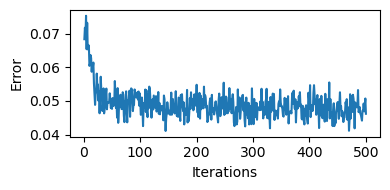

In [14]:
# Plot error
figure(figsize=(4, 2))
ylabel("Error")
xlabel("Iterations")
plot(1:num_iter, errorarr)
tight_layout()

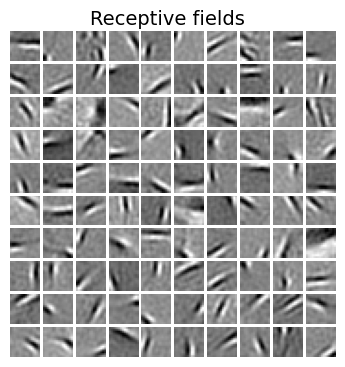

In [15]:
# Plot Receptive fields
figure(figsize=(4.2, 4))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:num_units
    subplot(10, 10, i)
    imshow(reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields", fontsize=14)
subplots_adjust(top=0.925)

In [16]:
H, W, num_images = size(imgs)
num_inputs = sz^2

# Get the coordinates of the upper left corner of clopping image randomly.
beginx = rand(1:W-sz, batch_size)
beginy = rand(1:H-sz, batch_size)

inputs = zeros(batch_size, num_inputs)  # Input image patches

# Get images randomly
for i in 1:batch_size        
    idx = rand(1:num_images)
    img = imgs[:, :, idx]
    clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
    inputs[i, :] = clop .- mean(clop)
end

model.r = zeros(batch_size, num_units) # Reset r states

# Input image patches until latent variables are converged 
r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

for t in 1:nt_max
    # Update r without update weights 
    error = updateOF!(model, model.param, inputs, false)

    dr = model.r - r_tm1 

    # Compute norm of r
    dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
    r_tm1 .= model.r # update r_tm1

    # Check convergence of r, then update weights
    if dr_norm < eps
        break
    end
end

In [17]:
println(model.r[1, :])

Float32[0.0, 0.0, 0.0, -0.10927324, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.038912714, 0.0, 0.0, 0.076857865, 0.0, 0.0, 0.0, 0.0, 0.0, -0.16639543, -0.08491037, 0.03819198, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14232533, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.029838407, 0.023829708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.25754452, 0.0, 0.34853616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.015220936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.21621448, 0.0, 0.0, 0.11461158, 0.0, 0.115215264, 0.0]


In [18]:
reconst = model.r * model.Phi'
println(size(reconst))

(250, 256)


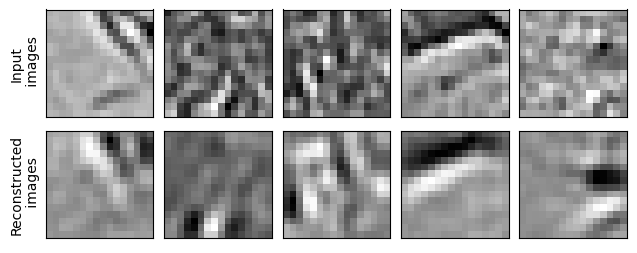

In [19]:
figure(figsize=(7.5, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
num_show = 5
for i in 1:num_show
    subplot(2, num_show, i)
    imshow(reshape(inputs[i, :], (sz, sz)), cmap="gray")
    xticks([]); yticks([]); 
    if i == 1
        ylabel("Input\n images")
    end

    subplot(2, num_show, num_show+i)
    imshow(reshape(reconst[i, :], (sz, sz)), cmap="gray")
    xticks([]); yticks([]); 
    if i == 1
        ylabel("Reconstructed\n images")
    end
end